## Prevendo valores de transações de imóveis no Rio de Janeiro

Neste projeto, iremos avaliar a performance e poder de predição de um modelo que foi treinado e testado em dados abertos coletados de imóveis no estado do Rio de Janeiro. O modelo treinado nesses dados que for considerado um bom ajuste pode ser usado para fazer previsões acerca do valor de transação de um imóvel. 

Os dados foram obtidos a partir do site [Data Rio](https://data.rio). Os dados de transação imobiliário são de 2010 até dia 11/03/2022 (momento da sua geração) e cada uma das 30763 entradas possuem 14 atributos sobre vários bairros do Rio de Janeiro. 

Dados de Transações Imobiliárias por Logradouro, na Cidade do Rio de Janeiro, segundo a Natureza de Compra e Venda e de Promessa e Compra e Venda, para imóveis Residenciais e Não Residenciais, segundo sua tipologia, a partir de 2010. Foram considerados por logradouro o número total de transações no ano, as médias de área construída, as médias de percentual do imóvel transacionado, a média do valor da transação e a média dos valores totais do imóvel, apurado pela relação entre o percentual transacionado e o valor da transação. Não estão contabilizadas observações com apenas uma transação no ano. 

Para o desenvolvimento do estudo, foram realizadas algumas formas de pré-processamento aos dados:
* Os atributos <mark>'Total_Transações'</mark>, <mark>'Uso'</mark>, <mark>'Principais_Tipologias'</mark>, <mark>'Média_Percentual_Transferido'</mark>, <mark>'Média_Área_Construída'</mark>,  <mark>'Média_Valor_Transação'</mark>, <mark>'Média_Valor_Imóvel'</mark> foram considerados importantes apriori e mantidos. Os demais foram **excluídos**.

* No atributo <mark>'Média_Área_Construída'</mark> foram observados 3 valores **faltantes**. Esses valores foram removidos.

* Uma das observações apresentou <mark>'Média_Valor_Imóvel'</mark> 3.29. Essa observação foi considerada um **outlier** e removida.

* O atributo <mark>'Zonas'</mark> foi **adicionado** a fim de registrar a zona em que localiza o imóvel observado.

* Os atributos **categóricos** foram transformados em atributos independentes de valor '0' ou '1' (one-hot encoding).

Em um primeiro passo, iremos ler os dados e separar as características de interesse e o valor da transação em diferentes dataframes do pandas.

In [1]:
# Importando pacotes para o trabalho
# visuals -> https://github.com/rromanss23/Machine_Leaning_Engineer_Udacity_NanoDegree/blob/master/projects/boston_housing/visuals.py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import visuals as vs 

from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import ShuffleSplit, train_test_split

# Pretty display for notebooks
%matplotlib inline

# https://www.data.rio/datasets/itbi-transa%C3%A7%C3%B5es-por-logradouro-im%C3%B3veis-residenciais-e-n%C3%A3o-residenciais/explore
# Dados gerados em 11/03/2022 14:29
df = pd.read_csv('Transações por logadouro residenciais e nao residenciais RJ (1).csv')

# Removendo algumas colunas que não serão utilizadas
df = df[['Bairro','Total_Transações','Uso','Principais_Tipologias','Média_Percentual_Transferido',
      'Média_Área_Construída', 'Média_Valor_Transação', 'Média_Valor_Imóvel']]

#prices = df['Média_Valor_Transação']
#ft = df.drop('Média_Valor_Transação', axis = 1)

# Output
print("Conjuntos de dados residenciais do Rio de Janeiro possui {} observações com {} variáveis cada.".format(*df.shape))

Conjuntos de dados residenciais do Rio de Janeiro possui 30763 observações com 8 variáveis cada.


### Limpando os dados

#### Removendo dados faltantes

In [2]:
df.isnull().sum()

Bairro                          0
Total_Transações                0
Uso                             0
Principais_Tipologias           0
Média_Percentual_Transferido    0
Média_Área_Construída           3
Média_Valor_Transação           0
Média_Valor_Imóvel              0
dtype: int64

In [3]:
# Salvando as linhas removidas caso haja interesse em avaliar futuramente avaliar futuramente
df_removido = df[df['Média_Área_Construída'].isna()]

# Removendo as linhas com Na's
df = df.dropna()
df.isnull().sum()

Bairro                          0
Total_Transações                0
Uso                             0
Principais_Tipologias           0
Média_Percentual_Transferido    0
Média_Área_Construída           0
Média_Valor_Transação           0
Média_Valor_Imóvel              0
dtype: int64

#### Removendo espaços em branco

In [4]:
# Removendo os espaços em branco
def remove_end_spaces(string):
    return "".join(string.rstrip())

df['Bairro'] = df['Bairro'].apply(remove_end_spaces)

#### Removendo outliers

In [5]:
# Removendo outliers
df = df.drop(index = 1421)
df = df.drop(index = 7108)

#### Adicionando zona às observações

In [6]:
# Adicionando coluna para definir zona
def obterZona(bairro):
    if bairro in ['Bairro Imperial de São Cristóvão', 'Benfica', 'Caju', 'Catumbi', 'Centro',
                  'Cidade Nova', 'Estácio', 'Gamboa', 'Lapa', 'Mangueira', 'Paquetá', 'Rio Comprido',
                  'Santa Teresa', 'Santo Cristo', 'Saúde', 'Vasco da Gama']:
        return 'Central'
    elif bairro in ['Botafogo', 'Catete', 'Copacabana', 'Cosme Velho', 'Flamengo', 'Gávea', 'Glória', 'Humaitá',
                    'Ipanema', 'Jardim Botânico', 'Lagoa' , 'Laranjeiras' ,'Leblon' , 'Leme' , 'São Conrado', 'Urca',
                    'Vidigal', 'Rocinha']:
        return 'Sul'
    elif bairro in ['Anil', 'Barra da Tijuca', 'Camorim', 'Cidade de Deus', 'Curicica', 'Freguesia de Jacarepaguá',
                    'Gardênia Azul' , 'Grumari' ,'Itanhangá' ,'Jacarepaguá' , 'Joá' , 'Praça Seca', 'Pechincha' ,
                    'Rio das Pedras', 'Recreio dos Bandeirantes', 'Tanque', 'Taquara', 'Vargem Grande',
                    'Vargem Pequena', 'Vila Valqueire', 'Jardim Sulacap',
                    
                   'Bangu', 'Campo dos Afonsos', 'Deodoro' , 'Gericinó', 'Jabour' , 'Magalhães Bastos', 'Padre Miguel',
                    'Realengo', 'Santíssimo','Senador Camará','Vila Kennedy', 'Vila Militar',
                   
                   'Barra de Guaratiba','Campo Grande' , 'Cosmos', 'Guaratiba', 'Inhoaíba', 'Paciência',
                    'Pedra de Guaratiba', 'Santa Cruz', 'Senador Vasconcelos', 'Sepetiba']:
        return 'Oeste'
    else:
        return 'Norte'
    
df['Zona'] = df['Bairro'].apply(obterZona)
df2 = df.copy()

def obterTipologia(tipo):
    if tipo in ['APARTAMENTO']:
        return 'APARTAMENTO'
    elif tipo in ['LOJA']:
        return 'LOJA'
    elif tipo in ['SALA']:
        return 'SALA'
    else:
        return 'OUTROS'
    
df2['Tipologias 2'] = df2['Principais_Tipologias'].apply(obterTipologia)

#### One-hot-encoding para variáveis categóricas

In [7]:
from sklearn.preprocessing import LabelBinarizer

# Binarizando a coluna "Uso": RESIDENCIAL = 1, NAO RESIDENCIAL = 0
lb = LabelBinarizer()
df["Uso"] = lb.fit_transform(df["Uso"])

# Transformando "Principais_Tipologias" em dummies
df = pd.get_dummies(df, columns=["Principais_Tipologias"],prefix = 'pt')

#Transformando 'Zona' em dummies
df = pd.get_dummies(df, columns=["Zona"],prefix = 'zona')

In [8]:
df = df.drop('Bairro',axis=1)
df.head()

,Total_Transações,Uso,Média_Percentual_Transferido,Média_Área_Construída,Média_Valor_Transação,Média_Valor_Imóvel,pt_APARTAMENTO,pt_APARTAMENTO (PROLETARIO),pt_ARMAZEM/DEPOSITO,pt_CASA (PROLETARIO),...,pt_GARAGEM/ESTACIONAMENTO,pt_LOJA,pt_LOJA SHOPPING,pt_SALA,pt_SOBRELOJA,pt_VAGA DE GARAGEM,zona_Central,zona_Norte,zona_Oeste,zona_Sul
0,3,1,100.00,22.00,50712.49,50712.49,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,3,1,100.00,40.66,89298.85,89298.85,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,13,1,100.00,190.07,2622818.63,2622818.63,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,16,1,96.87,173.75,1622825.12,1698048.91,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,16,1,97.91,164.87,2194938.45,2278524.74,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


## Explorando os dados

Faremos uma investigação preliminar sobre os dados dos imóveis localizados no Rio de Janeiro.

Como o objetivo principal é construir um modelo que seja capaz de prever o valor da transação dos imóveis, o conjunto de dados foi separado em **atributos** e **variável alvo**. Os **atributos** <mark>'Total_Transações'</mark>, <mark>'Média_Percentual_Transferido'</mark>, <mark>'Média_Área_Construída'</mark>, <mark>'Média_Valor_Imóvel'</mark> fornecem informações quantitativas sobre cada observação, enquanto as variáveis <mark>'Uso'</mark>, <mark>'Principais_Tipologias'</mark> e <mark>'Zonas'</mark> oferecem informações categóricas. A variável <mark>'Média_Valor_Transação'</mark> será a **variável alvo** que iremos prever. Essas informações foram guardadas em <mark>ft</mark> e <mark>prices</mark> respectivamente.


### Calculando estatísticas

Começaremos calculando algumas estatísticas acerca dos valores de transação.

In [9]:
prices = df['Média_Valor_Transação']
ft = df.drop('Média_Valor_Transação', axis = 1)


minimum_price = np.min(prices)
maximum_price = np.max(prices)
mean_price = np.mean(prices)
median_price = np.median(prices)
std_price = np.std(prices)

# Show the calculated statistics
print("Estatísticas para o conjunto de dados imobiliários:\n")
print("Preço mínimo: ${:,.2f}".format(minimum_price))
print("Preço máximo: ${:,.2f}".format(maximum_price))
print("Preço médio: ${:,.2f}".format(mean_price))
print("Preço mediano ${:,.2f}".format(median_price))
print("Desvio padrão dos preços: ${:,.2f}".format(std_price))

Estatísticas para o conjunto de dados imobiliários:

Preço mínimo: $588.33
Preço máximo: $31,980,839.97
Preço médio: $517,495.42
Preço mediano $269,894.63
Desvio padrão dos preços: $824,845.74


### Observando os atributos

Primeiro vamos observar as nossa **variáveis numéricas**: 'Total_Transações', 'Média_Percentual_Transferido', 'Média_Área_Construída' e 'Média_Valor_Imóvel'. Para cada observação:

* **'Total_Transações'** é o número total vezes em que o imóvel esteve envolvido em transações.
* **'Média_Percentual_Transferido'** é a média do percentual do valor do imóvel que foi pago durante a transação.
* **'Média_Área_Construída'** é a média da área do imóvel em 'm²'.
* **'Média_Valor_Imóvel'** é a média do valor do imóvel avaliado.

Antes de construir o modelo, queremos realizar uma análise exploratória que nos faça entender melhor a relação entre esses **atributos** e a variáveis de interesse 'Média_Valor_Transação'. É interessante entender se as variáveis explicativas possuem influência **positiva** ou **negativa**, assim como os níveis de correlação entre elas.

* **'Total_Transações'**: Um aumento no número de transações leva a uma **diminuição** em 'Média_Valor_Transação'. Isso talvez ocorra porque imóveis negociados por preços menores atinjam uma proporção maior da população e essa maior atratividade gere mais transações. É interessante notar que a relação entre as variáveis não é linear. Ao invés disso, parece possuir uma relação exponencial negativa.

* **'Média_Percentual_Transferido'**: Um aumento nesse atributo leva a um **aumento** em 'Média_Valor_Transação'. Essa relação aponta para o fato de que quanto maior o valor do imóvel, mais perto do valor real o comprador paga durante a transação. A relação entre essas variáveis parece ser exponencial positiva.

* **'Média_Área_Construída'**: Um aumento na área construida leva a um **aumento** em 'Média_Valor_Transação'. Isso é esperado, uma vez que propriedades maiores tendem a ser negociadas por valores mais altos. Essa relação parece ser linear positiva para a maioria dos pontos. É importante notar que essa variável tem uma correlação significativa com a variável 'Média_Valor_Imóvel', o que também é esperado, uma vez o valor real de propriedades maiores tende a ser maior.

* **'Média_Valor_Imóvel'**: Um aumento nesse atributo leva a um **aumento** em 'Média_Valor_Transação'. Há uma relação linear positiva bem forte aqui, o que parece ser natural. Imóveis com valor real mais alto tendem a ser negociados por valores maiores. Possui alta correlação com 'Média_Valor_Transação'.

Os gráficos de dispersão e correlação a seguir confirmam essas informações.

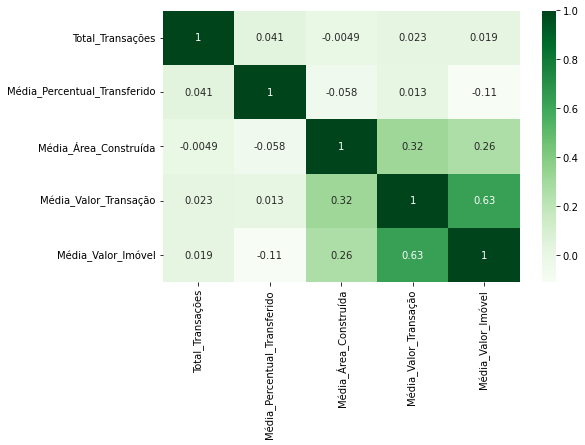

In [10]:
corr = df.iloc[: , [0,2,3,4,5]].corr()
plt.figure(figsize=(8,5))
sns.heatmap(corr, cmap="Greens",annot=True)
plt.show()

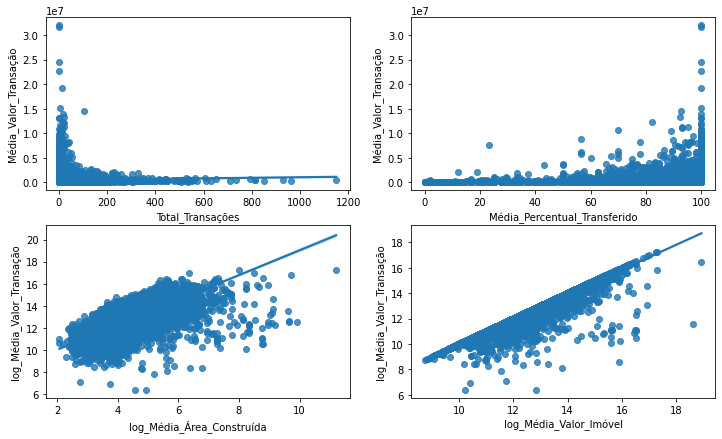

In [11]:
df['log_Média_Área_Construída'] = np.log(df['Média_Área_Construída'])
df['log_Média_Valor_Transação'] = np.log(df['Média_Valor_Transação'])
df['log_Média_Valor_Imóvel'] = np.log(df['Média_Valor_Imóvel'])

fig, axs = plt.subplots(2,2,figsize=(12, 7))
#plt.figure(figsize=(11,8))
sns.regplot(x='Total_Transações', y='Média_Valor_Transação', data=df, ax=axs[0,0])
sns.regplot(x='Média_Percentual_Transferido', y='Média_Valor_Transação', data=df, ax=axs[0,1])
sns.regplot(x='log_Média_Área_Construída',y='log_Média_Valor_Transação', data=df, ax=axs[1,0])
sns.regplot(x='log_Média_Valor_Imóvel',y='log_Média_Valor_Transação', data=df, ax=axs[1,1])

df = df.drop('log_Média_Área_Construída',axis=1)
df = df.drop('log_Média_Valor_Transação',axis=1)
df = df.drop('log_Média_Valor_Imóvel',axis=1)

Primeiro vamos observar as nossa **variáveis categóricas**: 'Uso', 'Principais_Tipologias' e 'Zonas'. Essas variáveis foram transformadas em colunas binárias para cada categoria, mas para essa análise exploratória olharemos para elas no formato original:

* **'Uso'** é a forma como o imóvel é utilizado. Possui 2 categorias: 'RESIDENCIAL' e 'NAO RESIDENCIAL'.
* **'Principais_Tipologias'** é o tipo do imóvel. Possui 12 categorias: 'APARTAMENTO', 'LOJA', 'SALA', 'CASA/APTO (PROLETARIO)', 'GALPAO', 'VAGA DE GARAGEM', 'SOBRELOJA', 'APARTAMENTO (PROLETARIO)', 'LOJA SHOPPING', 'ARMAZEM/DEPOSITO', 'CASA (PROLETARIO)' e 'GARAGEM/ESTACIONAMENTO'.
* **'Zona'** é a zona do estado em que o imóvel se encontra. Possui 4 categorias: 'Norte', 'Oeste', 'Central' e 'Sul'.

Observamos que a maioria dos imóveis são apartamentos residenciais na Zona Norte. Há também um visível desbalanceamento entre as categorias.

<AxesSubplot:xlabel='Zona', ylabel='count'>

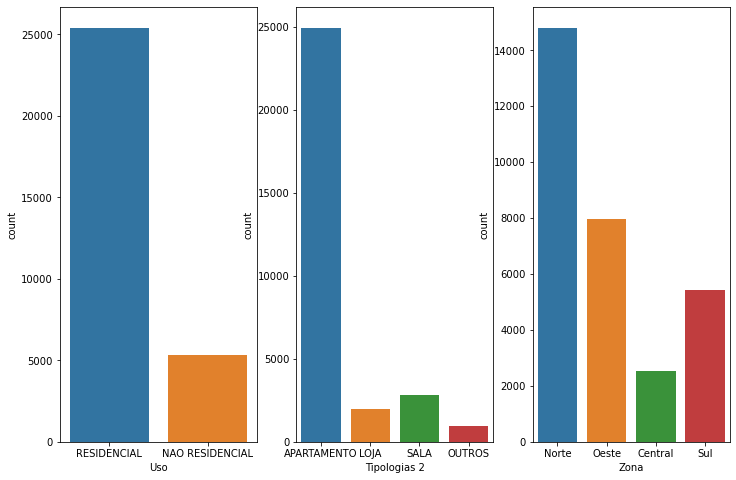

In [13]:
fig, axs = plt.subplots(ncols=3,figsize=(12, 8))

sns.countplot(x='Uso',data=df2, ax=axs[0])
sns.countplot(x='Tipologias 2',data=df2,ax=axs[1])
sns.countplot(x="Zona",data=df2, ax=axs[2])

## Desenvolvendo um modelo

Nessa sessão do projeto, iremos desenvolver as técnicas necessárias para um modelo ser capaz de tomar uma decisão. Ser capaz de realizar avaliações sobre cada performance do modelo através desses métodos e ferramentas ajuda a reforçar a confiança nas predições.

### Definir uma métrica de performance

Para esse projeto, utilizaremos o coeficiente de determinação, R², para quantificar a performance do modelo. O coeficiente de determinação é uma estatística útil na análise de regressão, uma vez que descreve quão "bom" o modelo é em fazer previsões.

Os valores de R² variam entre 0 e 1, o que captura a porcentagem da correlação quadrada entre os valores preditos e os valores reais da variavel alvo. Um modelo em que R² é 0 não é melhor que um modelo que sempre prevê a média da variável alvo, já um modelo em que R² é 1 pervê perfeitamente a variável alvo. Qualquer valor entre 0 e 1 indica qual a porcentagem da variável alvo, utilizando o modelo, pode ser explicada pelos atributos.

Uma função para retornar o score R² dado o valor real e o valor previsto é:

In [14]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    score = r2_score(y_true,y_predict)
    
    # Return the score
    return score

### Embaralhando e dividindo os dados

Agora vamos pegas os dados e dividi-los em subconjuntos de treino e teste. Usualmente, os dados também são embaralhadso em ordem aleatória quando criamos esses subconjuntos, a fim de remover qualquer viéis dado pela sua ordenação.

Após realizar essa divisão, poderemos treinar um modelo no conjunto de treino, alimenta-lo com dados desconhecidos do conjunto de teste e avaliar sua performance.

In [30]:
from sklearn.model_selection import train_test_split

# Embaralhando e dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(ft,prices,test_size=0.2,random_state=42)

# Success
print("Divisão em treino e teste realizada com sucesso.")

Divisão em treino e teste realizada com sucesso.


### Analizando a performance do modelo

Nesta sessão olharemos para várias performance de teste e aprendizado do modelo em vários subconjuntos de dados de treino. Além disso, observaremos como o aumento da **profundidade**('max_depth') do algoritmo de uma **árvore de decisão** em todos os dados de treino para verificar como a complexidade do modelo afeta a performance. 


#### Curvas de aprendizado

A seguir são produzidos quatro gráficos para o modelo de árvore de decisão com diferentes valores de 'max_depth'. Cada gráfico produz uma visualização da curva de aprendizado do modelo para treinamento e teste, conforme o tamanho do conjutno de treino aumento. A região sombreada da curva de aprendizado denota a incerteza da curva (desvio padrão). Esse modelo é avaliado usando R². 

*Nota: Essa sessão usa funções disponíveis no module 'visuals'.*

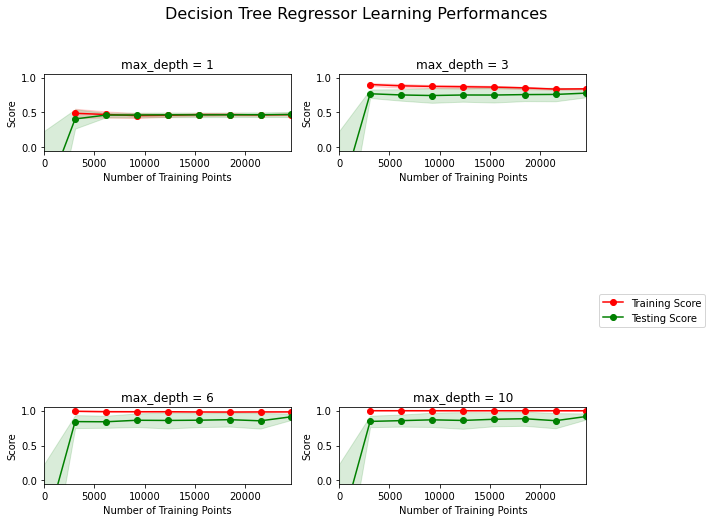

In [31]:
import warnings
warnings.filterwarnings("ignore")  # suppress warnings
vs.ModelLearning(ft, prices) 

Se olharmos para o gráfico com max_depth = 3, vemos que a curva de treino parece ter a inclinação levemente negativa e quanto mais pontos são adicionados, o score da curva de treino decresce até estabilizar em torno de 0.7. Ao mesmo tempo, adicionar mais pontos de treino não parece aumentar muito o score dos dados de teste, que parece se estabilizar próximo de 0.7. No entanto, podemos ver que para um número extremamente grande de pontos de treino as duas curvas parecem convergir para o mesmo valor.

#### Curvas de complexidade

O gráfico a seguir é referente a um modelo de árvore de decisão que foi treinado e validado nos dados de treino usando valores diferentes de 'max_depth'. Podemos ver duas curvas de complexidade, uma para treinamento e uma para validação. Similares às curvas de aprendizado, as regiões sombreadas denotam a incenteza dessas curvas, e o modelo é avaliado em ambos os conjuntos usando a função 'perfomance_metric'.

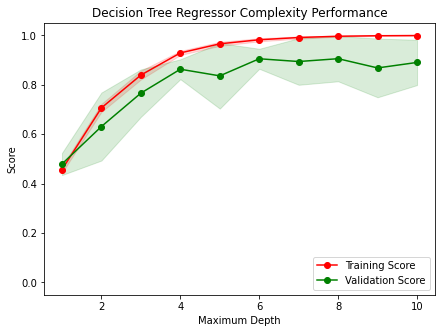

In [32]:
vs.ModelComplexity(X_train, y_train)

#### Tradeoff viéis-variância

* Quando o modelo é treinado com 'max_depth' = 1, o modelo tem alto viéis porque os scores de treino e teste são ambos baixos e, consequentemente, o modelo estará subajustando os dados.

* Quando o modelo é treinado com 'max_depth' = 10, o modelo tem baixo viéis e parece não ter uma variância tão alta que justifique classificar como sobreajuste. O coeficiente de variação R² é um pouco maior para os dados de treino, mas nada extremamente significativo.

**Qual seria o melhor modelo intuitivamente?** O 'max_depth' = 6 'max_depth' = 8 parecem ser os que melhor generalizam os dados fora do conjunto de treino. Seria interessante avaliar para profundidades maiores do que 10, uma vez que não há indicação de que o modelo não melhorará.

### Ajustando o modelo

Utilizamos a técnica de **Grid Search** para escolher entre diferentes combinações de parâmetros, enquanto usavamos **Validação Cruzada** com 3 dobras nos resultados para determinar a combinação de parâmetros que fornecessem a melhor performance baseada em uma técnica de avaliação. 

In [40]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

dt_reg = DecisionTreeRegressor()

# Inicializando os hiperparâmetros para o ajuste

parameters={"splitter":["best","random"],
            "max_depth" : [6,8,10,11,12],
           "min_samples_leaf":[1,2,3,4,5],
           "min_weight_fraction_leaf":[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
           "max_features":["auto","log2","sqrt",None],
           "min_samples_split":[1,2,3,4,5],
           "max_leaf_nodes":[None,10,20,30,40] }

modelo_ajustado_1 = GridSearchCV(dt_reg,param_grid=parameters,
                          scoring='neg_mean_squared_error',cv=3,verbose=1)

In [41]:
# Ajustando os hiperparâmetros com GridSearchCV
modelo_ajustado_1.fit(X_train,y_train)

Fitting 3 folds for each of 10000 candidates, totalling 30000 fits


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [6, 8, 10, 11, 12],
                         'max_features': ['auto', 'log2', 'sqrt', None],
                         'max_leaf_nodes': [None, 10, 20, 30, 40],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_weight_fraction_leaf': [0, 0.1, 0.2, 0.3, 0.4,
                                                      0.5, 0.6, 0.7, 0.8, 0.9],
                         'splitter': ['best', 'random']},
             scoring='neg_mean_squared_error', verbose=1)

In [83]:
modelo_ajustado_1.best_estimator_

DecisionTreeRegressor(max_depth=11, min_samples_leaf=2,
                      min_weight_fraction_leaf=0)

In [47]:
modelo_ajustado_1.best_params_

{'max_depth': 11,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_samples_leaf': 2,
 'min_weight_fraction_leaf': 0,
 'splitter': 'best'}

### Fazendo Previsões

Uma vez que o modelo foi treinado, ele pode ser usado para fazer previsões em novos dados não observados. No caso da árvore de decisão para regressão, o modelo aprendeu quais as melhores questões a serem perguntadas aos dados de entrada, e pode responder com uma previsão para a **variável alvo**. 

### Modelo ótimo

O melhor modelo foi aquele com 'max_depth' = 11. Esse hiperparâmetro é diferente de 6 ou 8 que pareceram ser boas aproximações, mas não é completamente fora da análise realizada, dado que para 'max_depth' = 10 ainda tinhamos bons resultados.

O modelo gerado com os parâmetros resultantes da seleção teve **acurácia** de aproximadamente 97.5% no conjunto de teste.

In [56]:
# Gerando o modelo com os melhores parâmetros
reg_decision_model=DecisionTreeRegressor(max_depth= 11, max_features= None,max_leaf_nodes= None,
                                         min_samples_leaf= 2, min_weight_fraction_leaf= 0,
                                         splitter= 'best')
# fit independent varaibles to the dependent variables
reg_decision_model.fit(X_train,y_train)

reg_decision_model.score(X_test,y_test)

0.9751508125112186

### Prevendo os valores de transação

Supondo que três clientes estejam interessados em vender seus imóveis e precisam de uma estimativa para o valor da transação. A seguir, as informações dos clientes:

| Atributo | Cliente 1 |  Cliente 2 |  Cliente 3 
| --- | ----------- | ----------- | -----------  
| Total de Transações | 1 |  2 | 5
| Média do Percentual Transferido | 99 |  85 | 100 
| Média da Área Construída | 300 |  100 | 30 
| Média do Valor do Imóvel | 1239022 |  150000 | 25000 
| Uso | Residencial |  Residencial | Não Residencial 
| Tipologia | Apartamento | Apartamento (Proletario) | Armazem/Deposito  
| Zona | Sul |  Oeste | Norte 

Vamos verificar quais preços o modelo selecionado vai prever para esses cliente, e se eles são razoáveis dados os atributos.

In [85]:
# Data Frame com os dados dos clientes
clientes_df = pd.DataFrame(columns=X_test.columns,index=['Cliente 1','Cliente 2','Cliente 3'])
clientes_df.loc['Cliente 1'] = [1, 1, 99, 300, 1239022, 1,
               0,0,0,0,0,0,0,0,0,0,0,
              0,0,0,1]
clientes_df.loc['Cliente 2'] = [2, 1, 85, 100, 150000, 0,
               1,0,0,0,0,0,0,0,0,0,0,
              0,0,1,0]
clientes_df.loc['Cliente 3'] = [5, 0, 100, 30, 25000, 0,
               0,1,0,0,0,0,0,0,0,0,0,
              0,1,0,0]

# Previsões
for i, price in enumerate(reg_decision_model.predict(clientes_df)):
    print("A previsão do preço da transação para o Ciente {} é: ${:,.2f}".format(i+1, price))

A previsão do preço da transação para o Ciente 1 é: $1,243,636.23
A previsão do preço da transação para o Ciente 2 é: $115,967.78
A previsão do preço da transação para o Ciente 3 é: $24,683.25


Aqui terminamos o projeto. Foi construida uma árvore de decisão para regressão que performa razoavelmente bem dados os 7 atributos selecionados.

Obviamente, o modelo não possui aplicação no mundo real, uma vez que deixa de incluir diversas características importantes como idade do imóvel, taxa de crime no bairro, acesso ao transporte público, etc. 

Como os bairros, em geral, têm mais influência no valor de venda do que as zonas em que eles se encontram, seria interessante expandir a análise para cada um deles a fim de obter modelos mais específicos e capazes de prever com mais precisão. Aqui foi decidido não utilizar esse tipo de divisão porque teriamos um Data Frame de dimensão muito grande, o que tornaria o processamento muito custoso.